In [12]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.fftpack import ifft
from scipy.interpolate import interp1d
from functools import partial
import scipy.stats as ss
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('complete_dataset.csv')

In [3]:
df = df[df['date'] > '2023-07-15']

In [7]:
# df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']
# df_filtered = df[
#    (df['spread_pct'] <= 0.1) &  # bid-ask spread <= 10%
#    (df['moneyness'] >= -0.105) & (df['moneyness'] <= 0.095) &  # log moneyness ±0.5
#    (df['days_to_expiry'] >= 7) & (df['days_to_expiry'] <= 45)  # 7-365 days
# ].copy()

In [8]:
# Group by date and get only calls
# grouped_by_date = df_filtered[df_filtered['call_put'] == 'Call'].groupby('date')

# call_data = {}
# for date, group in grouped_by_date:
#    call_data[date] = group.pivot_table(
#        index='strike', 
#        columns='expiration', 
#        values='mid_price', 
#        aggfunc='first'
#    )

In [4]:
df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']
df_filtered = df[
   (df['spread_pct'] <= 0.1) &  
   (df['moneyness'] >= -0.105) & (df['moneyness'] <= 0.095) &  
   (df['days_to_expiry'] >= 7) & (df['days_to_expiry'] <= 45)  
].copy()

# only CALLS now
grouped_by_date = df_filtered[df_filtered['call_put'] == 'Call'].groupby('date')

call_data = {}
for date, group in grouped_by_date:
   # find maturity with most data points
   maturity_counts = group.groupby('expiration').size()
   best_maturity = maturity_counts.idxmax()
   
   # get data for best maturity only
   best_maturity_data = group[group['expiration'] == best_maturity]
   call_data[date] = {
       'maturity': best_maturity,
       'prices': best_maturity_data.set_index('strike')['mid_price'].sort_index(),
       'spot_price': best_maturity_data['spot_price'].iloc[0],
       'risk_free_rate': best_maturity_data['risk_free_rate'].iloc[0],
       'time_to_expiry': best_maturity_data['time_to_expiry'].iloc[0],
       'dividend_yield': best_maturity_data['dividend_yield'].iloc[0]
   }

In [86]:
call_data

{'2023-07-17': {'maturity': '2023-08-11',
  'prices': strike
  395.0    57.175
  405.0    47.285
  415.0    37.445
  424.0    28.705
  433.0    20.205
  442.0    12.355
  451.0     5.950
  460.0     2.075
  468.0     0.625
  Name: mid_price, dtype: float64,
  'spot_price': 437.4855575360118,
  'risk_free_rate': 0.0523299980163574,
  'time_to_expiry': 0.0992063492063492,
  'dividend_yield': 0.0116},
 '2023-07-19': {'maturity': '2023-08-02',
  'prices': strike
  400.0    56.055
  410.0    46.105
  420.0    36.170
  430.0    26.290
  440.0    16.635
  446.0    11.210
  455.0     4.600
  463.0     1.365
  470.0     0.335
  Name: mid_price, dtype: float64,
  'spot_price': 443.2130865430364,
  'risk_free_rate': 0.0524499988555908,
  'time_to_expiry': 0.0555555555555555,
  'dividend_yield': 0.0116},
 '2023-07-21': {'maturity': '2023-08-18',
  'prices': strike
  407.0    47.315
  416.0    38.485
  425.0    29.770
  434.0    21.290
  444.0    12.555
  452.0     6.810
  462.0     2.225
  470.0  

In [11]:
sample = call_data["2023-10-06"]

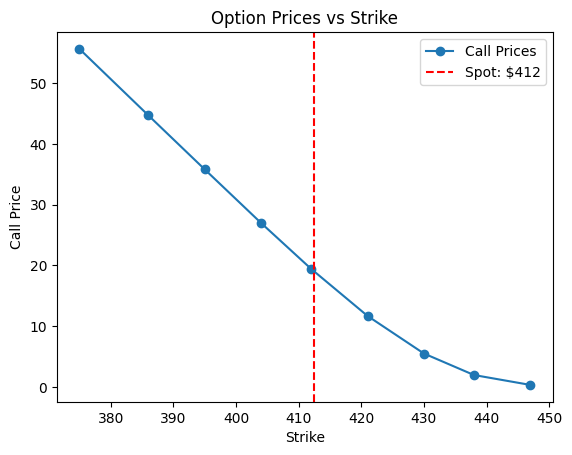

In [ ]:
# Plot the option prices vs strikes to see the convexity
sample = call_data["2023-10-06"]
plt.plot(sample['prices'].index, sample['prices'].values, 'o-', label='Call Prices')
plt.axvline(sample['spot_price'], color='red', linestyle='--', label=f"Spot: ${sample['spot_price']:.0f}")
plt.xlabel('Strike'); plt.ylabel('Call Price'); plt.legend(); plt.title('Option Prices vs Strike'); plt.show()

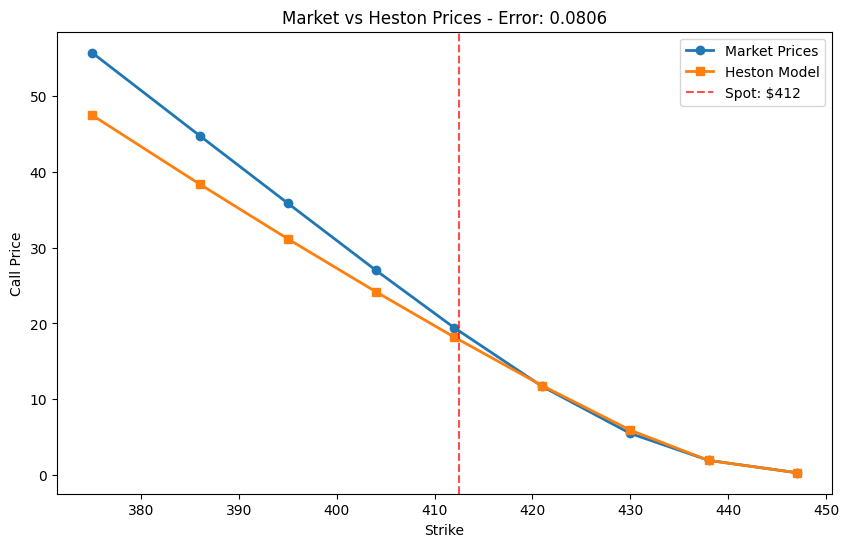

In [ ]:
# get the calibrated parameters for this date
calibrated = calibration_results["2023-10-06"]
sample = call_data["2023-10-06"]

heston_process = HestonProcess(
    kappa=calibrated['kappa'], theta=calibrated['theta'], 
    sigma=calibrated['sigma'], rho=calibrated['rho'], 
    v0=calibrated['v0'], r=sample['risk_free_rate']
)
heston_pricer = HestonPricer(heston_process)

strikes = sample['prices'].index.values
heston_prices = heston_pricer.fft_price(strikes, sample['spot_price'], sample['time_to_expiry'])
plt.figure(figsize=(10,6))
plt.plot(strikes, sample['prices'].values, 'o-', label='Market Prices', linewidth=2)
plt.plot(strikes, heston_prices, 's-', label='Heston Model', linewidth=2)
plt.axvline(sample['spot_price'], color='red', linestyle='--', alpha=0.7, label=f"Spot: ${sample['spot_price']:.0f}")
plt.xlabel('Strike'); plt.ylabel('Call Price'); plt.legend(); plt.title(f'Market vs Heston Prices - Error: {calibrated["error"]:.4f}'); plt.show()

In [21]:
comparison = pd.DataFrame({
    'Strike': strikes,
    'Market_Price': sample['prices'].values,
    'Heston_Price': heston_prices,
    'Difference': sample['prices'].values - heston_prices,
    'Pct_Error': 100 * (heston_prices - sample['prices'].values) / sample['prices'].values
})
print(comparison.round(4))

   Strike  Market_Price  Heston_Price  Difference  Pct_Error
0   375.0        55.670       47.4447      8.2253   -14.7750
1   386.0        44.730       38.3462      6.3838   -14.2718
2   395.0        35.830       31.1383      4.6917   -13.0943
3   404.0        27.000       24.1689      2.8311   -10.4855
4   412.0        19.435       18.1998      1.2352    -6.3554
5   421.0        11.690       11.7959     -0.1059     0.9057
6   430.0         5.500        5.9299     -0.4299     7.8172
7   438.0         1.955        1.9464      0.0086    -0.4393
8   447.0         0.325        0.3240      0.0010    -0.3004


In [5]:
# heston calibration

class HestonProcess:

    def __init__(self, kappa=2.0, theta=0.04, sigma=0.3, rho=-0.5, v0=0.04, r=0.05):
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.v0 = v0
        self.r = r

class HestonPricer:
    """FFT method"""
    
    def __init__(self, process_params):
        self.params = process_params
    
    def characteristic_function(self, u, T):
        kappa, theta, sigma, rho, v0, r = (
            self.params.kappa, self.params.theta, self.params.sigma,
            self.params.rho, self.params.v0, self.params.r
        )
        
        xi = kappa - sigma * rho * u * 1j
        d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j * u))
        
        # Avoid division by zero!
        g1 = (xi + d) / (xi - d)
        g2 = 1 / g1
        
        # characteristic function
        cf = np.exp(
            1j * u * r * T + 
            (kappa * theta) / (sigma**2) * (
                (xi - d) * T - 2 * np.log((1 - g2 * np.exp(-d * T)) / (1 - g2))
            ) +
            (v0 / sigma**2) * (xi - d) * (1 - np.exp(-d * T)) / (1 - g2 * np.exp(-d * T))
        )
        
        return cf
    
    def fft_price(self, strikes, S0, T, N=2**15):
        strikes = np.array(strikes)
        
        # FFT parameters
        B = 500  # integration limit
        dx = B / N
        x = np.arange(N) * dx
        
        # simpson weights
        weight = 3 + (-1)**(np.arange(N) + 1)
        weight[0] = 1
        weight[N-1] = 1
        
        # wavenumber grid
        dk = 2 * np.pi / B
        b = N * dk / 2
        ks = -b + dk * np.arange(N)
        
        # integrand for call options
        cf_values = self.characteristic_function(x - 0.5j, T)
        integrand = (np.exp(-1j * b * np.arange(N) * dx) * 
                    cf_values * 1/(x**2 + 0.25) * weight * dx / 3)
        
        # FFT and interpolation
        integral_value = np.real(ifft(integrand) * N)
        spline = interp1d(ks, integral_value, kind="cubic", 
                         bounds_error=False, fill_value=0)
        
        # Call prices
        prices = (S0 - np.sqrt(S0 * strikes) * np.exp(-self.params.r * T) / np.pi * 
                 spline(np.log(S0 / strikes)))
        
        return np.maximum(prices, 0.001) 

In [6]:
# 2. calibratin engine
class HestonCalibrator:
    """calibrates to market data"""
    
    def __init__(self):
        self.best_params = None
        self.calibration_error = None
    
    def objective_function(self, params, market_data):
        """objective function"""
        kappa, theta, sigma, rho, v0 = params
        
        process = HestonProcess(
            kappa=kappa, theta=theta, sigma=sigma, rho=rho, v0=v0,
            r=market_data['risk_free_rate']
        )
        
        pricer = HestonPricer(process)
        
        try:
            # price options with current parameters
            model_prices = pricer.fft_price(
                strikes=market_data['strikes'],
                S0=market_data['spot_price'], 
                T=market_data['time_to_expiry']
            )
            
            # calculate weighted squared errors
            market_prices = market_data['market_prices']
            weights = 1.0 / market_prices  # Inverse price weighting
            
            errors = (model_prices - market_prices) * weights
            return np.sum(errors**2)
            
        except:
            return 1e10  # return large error if pricing fails
    
    def calibrate(self, market_data, initial_guess=None):
        
        if initial_guess is None:
            initial_guess = [2.0, 0.04, 0.3, -0.5, 0.04]  
        bounds = [
            (0.1, 10.0),    # kappa: mean reversion speed
            (0.01, 1.0),    # theta: long-term variance  
            (0.01, 5.0),    # sigma: vol of vol
            # (0.01, 2.0),    # sigma: vol of vol
            (-0.99, 0.99),  # rho: correlation
            (0.001, 1.0)    # v0: initial variance
        ]
        
        # optimization
        result = minimize(
            self.objective_function,
            initial_guess,
            args=(market_data,),
            # method='L-BFGS-B',
            method = 'SLSQP',
            bounds=bounds,
            options={'maxiter': 1000, 'ftol': 1e-8}
        )
        
        if result.success:
            self.best_params = result.x
            self.calibration_error = result.fun
            return {
                'kappa': result.x[0],
                'theta': result.x[1], 
                'sigma': result.x[2],
                'rho': result.x[3],
                'v0': result.x[4],
                'error': result.fun,
                'success': True
            }
        else:
            return {
                'error': result.fun,
                'success': False,
                'message': result.message
            }

In [7]:
# 3. daily calibration
def run_daily_calibration(call_data):
    calibrator = HestonCalibrator()
    calibration_results = {}
    
    for date, data in call_data.items():
        print(f"\nCalibrating for {date}:")
        print(f"  Maturity: {data['maturity']}")
        print(f"  Spot Price: ${data['spot_price']:.2f}")
        print(f"  Time to Expiry: {data['time_to_expiry']:.4f} years")
        print(f"  Number of strikes: {len(data['prices'])}")

        market_data = {
            'strikes': data['prices'].index.values,
            'market_prices': data['prices'].values,
            'spot_price': data['spot_price'],
            'risk_free_rate': data['risk_free_rate'],
            'time_to_expiry': data['time_to_expiry']
        }
        # run 
        result = calibrator.calibrate(market_data)
        
        if result['success']:
            print(f"    κ : {result['kappa']:.4f}")
            print(f"    θ :  {result['theta']:.4f}")
            print(f"    σ :     {result['sigma']:.4f}")
            print(f"    ρ :    {result['rho']:.4f}")
            print(f"    v0 :   {result['v0']:.4f}")
            print(f"    error:  {result['error']:.6f}")
            
            # check Feller condition (just for information)
            feller_value = 2 * result['kappa'] * result['theta'] - result['sigma']**2
            feller_satisfied = feller_value >= 0
            print(f"    Feller condition:   {'Satisfied' if feller_satisfied else 'Violated'} ({feller_value:.4f})")
            
        else:
            print(f" failed: {result.get('message', 'Unknown error')}")
        
        calibration_results[date] = {
            **result,
            'market_data': market_data,
            'feller_condition': 2 * result.get('kappa', 0) * result.get('theta', 0) - result.get('sigma', 0)**2 if result['success'] else None
        }
    
    successful_calibrations = sum(1 for r in calibration_results.values() if r['success'])
    total_calibrations = len(calibration_results)
    
    print(f"successful calibrations: {successful_calibrations}/{total_calibrations}")
    
    if successful_calibrations > 0:
        # Summary statistics
        successful_results = [r for r in calibration_results.values() if r['success']]
        
        avg_kappa = np.mean([r['kappa'] for r in successful_results])
        avg_theta = np.mean([r['theta'] for r in successful_results])
        avg_sigma = np.mean([r['sigma'] for r in successful_results])
        avg_rho = np.mean([r['rho'] for r in successful_results])
        avg_v0 = np.mean([r['v0'] for r in successful_results])
        avg_error = np.mean([r['error'] for r in successful_results])
        
        feller_violations = sum(1 for r in successful_results if r['feller_condition'] < 0)
        
        print(f"\naverage:")
        print(f"  κ : {avg_kappa:.4f}")
        print(f"  θ :  {avg_theta:.4f}")
        print(f"  σ :     {avg_sigma:.4f}")
        print(f"  ρ :    {avg_rho:.4f}")
        print(f"  v0 :   {avg_v0:.4f}")
        print(f"  average error:      {avg_error:.6f}")
        print(f"  Feller violations:  {feller_violations}/{successful_calibrations}")
    
    return calibration_results

In [8]:
calibration_results = run_daily_calibration(call_data)


Calibrating for 2023-07-17:
  Maturity: 2023-08-11
  Spot Price: $437.49
  Time to Expiry: 0.0992 years
  Number of strikes: 9
    κ : 3.3815
    θ :  0.0100
    σ :     5.0000
    ρ :    -0.9476
    v0 :   0.2217
    error:  0.025340
    Feller condition:   Violated (-24.9324)

Calibrating for 2023-07-19:
  Maturity: 2023-08-02
  Spot Price: $443.21
  Time to Expiry: 0.0556 years
  Number of strikes: 9
    κ : 1.3619
    θ :  0.0100
    σ :     5.0000
    ρ :    -0.9583
    v0 :   0.1924
    error:  0.049021
    Feller condition:   Violated (-24.9728)

Calibrating for 2023-07-21:
  Maturity: 2023-08-18
  Spot Price: $442.19
  Time to Expiry: 0.1111 years
  Number of strikes: 8
    κ : 9.3796
    θ :  0.0100
    σ :     5.0000
    ρ :    -0.9193
    v0 :   0.1939
    error:  0.014072
    Feller condition:   Violated (-24.8124)

Calibrating for 2023-07-24:
  Maturity: 2023-08-18
  Spot Price: $441.62
  Time to Expiry: 0.0992 years
  Number of strikes: 8
    κ : 4.3560
    θ :  0.0100
 

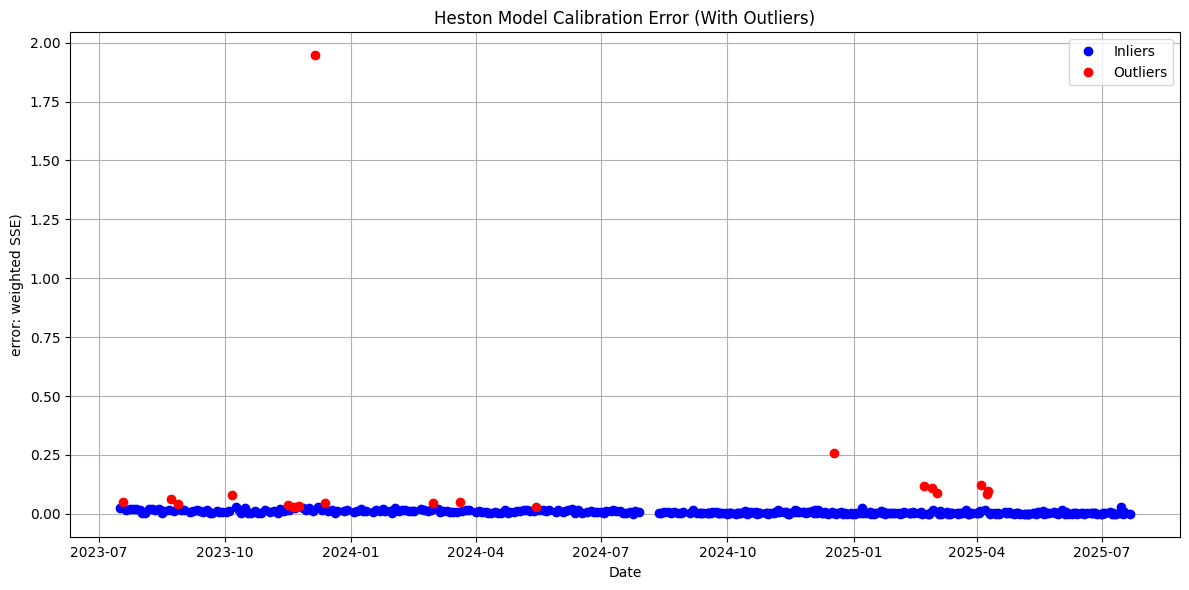

      Date  Calibration Error
2023-07-19           0.049021
2023-08-23           0.061278
2023-08-28           0.040817
2023-10-06           0.080600
2023-11-16           0.037089
2023-11-20           0.030120
2023-11-22           0.030345
2023-11-24           0.031360
2023-12-06           1.946335
2023-12-13           0.046087
2024-03-01           0.047543
2024-03-20           0.048787
2024-05-15           0.029692
2024-12-18           0.258649
2025-02-21           0.116713
2025-02-27           0.110496
2025-03-03           0.089085
2025-04-04           0.121030
2025-04-08           0.086107
2025-04-09           0.098527


In [13]:

dates = []
errors = []

for date, result in calibration_results.items():
    if result['success']:
        dates.append(pd.to_datetime(date))
        errors.append(result['error'])

dates = np.array(dates)
errors = np.array(errors)

# use IQR to detect outliers
Q1 = np.percentile(errors, 25)
Q3 = np.percentile(errors, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# filter
inlier_mask = (errors >= lower_bound) & (errors <= upper_bound)
outlier_mask = ~inlier_mask

inlier_dates = dates[inlier_mask]
inlier_errors = errors[inlier_mask]

outlier_dates = dates[outlier_mask]
outlier_errors = errors[outlier_mask]


plt.figure(figsize=(12, 6))
plt.plot(inlier_dates, inlier_errors, 'bo', label='Inliers')
plt.plot(outlier_dates, outlier_errors, 'ro', label='Outliers')
plt.title('Heston Model Calibration Error (With Outliers)')
plt.xlabel('Date')
plt.ylabel('error: weighted SSE)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
outlier_df = pd.DataFrame({'Date': outlier_dates, 'Calibration Error': outlier_errors})
print(outlier_df.sort_values('Date').to_string(index=False))

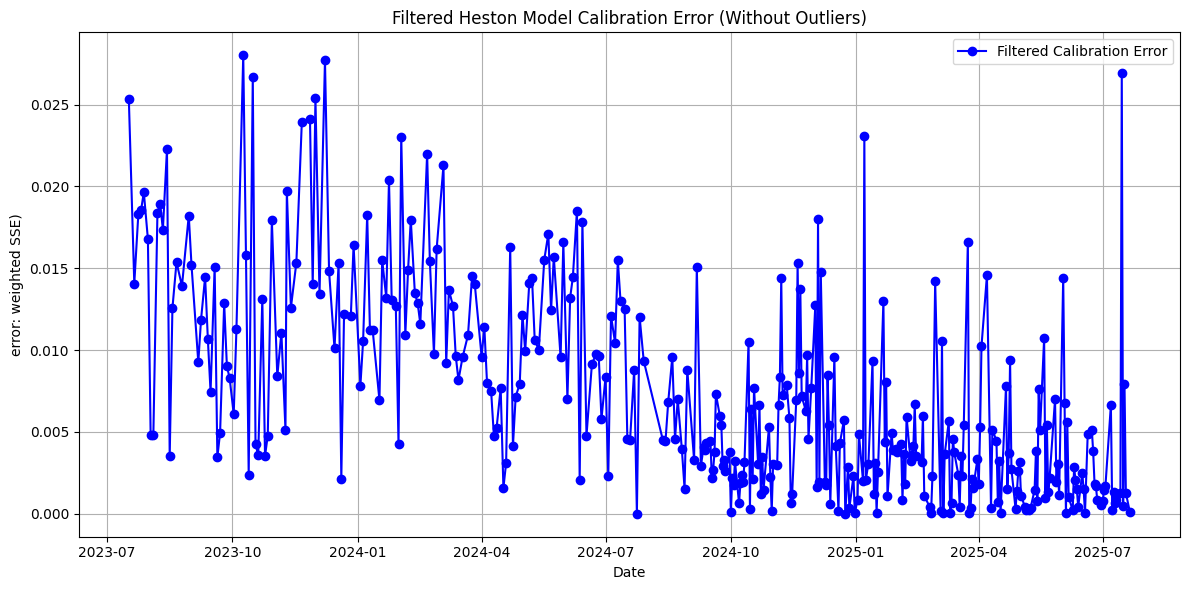

In [14]:
# without outeliers
dates = []
errors = []

for date, result in calibration_results.items():
    if result['success']:
        dates.append(pd.to_datetime(date))
        errors.append(result['error'])

dates = np.array(dates)
errors = np.array(errors)

Q1 = np.percentile(errors, 25)
Q3 = np.percentile(errors, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (errors >= lower_bound) & (errors <= upper_bound)
filtered_dates = dates[mask]
filtered_errors = errors[mask]

plt.figure(figsize=(12, 6))
plt.plot(filtered_dates, filtered_errors, marker='o', linestyle='-', color='blue', label='Filtered Calibration Error')
plt.title('Filtered Heston Model Calibration Error (Without Outliers)')
plt.xlabel('Date')
plt.ylabel('error: weighted SSE)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [97]:
daily_params = pd.DataFrame({date: {k: v for k, v in result.items() if k in ['kappa', 'theta', 'sigma', 'rho', 'v0', 'error']} 
                           for date, result in calibration_results.items() if result['success']}).T

In [98]:
daily_params

,kappa,theta,sigma,rho,v0,error
2023-07-17,3.381550,0.010000,5.000000,-0.947636,0.221699,0.025340
2023-07-19,1.361923,0.010000,5.000000,-0.958317,0.192417,0.049021
2023-07-21,9.379550,0.010000,5.000000,-0.919252,0.193851,0.014072
2023-07-24,4.355960,0.010000,5.000000,-0.950108,0.222276,0.018345
2023-07-26,2.754528,0.010000,5.000000,-0.954655,0.224523,0.018563
...,...,...,...,...,...,...
2025-07-15,0.540011,0.010000,0.037093,0.990000,0.006209,0.026927
2025-07-16,3.386579,0.075242,0.698905,-0.629936,0.002094,0.000465
2025-07-17,1.382005,0.200156,1.027756,-0.786865,0.009607,0.007943
2025-07-18,3.420975,0.033990,0.247409,-0.437648,0.003735,0.001276


In [99]:
daily_params.to_csv('heston_daily_parameters.csv')

Try use both calls and puts to calibrate

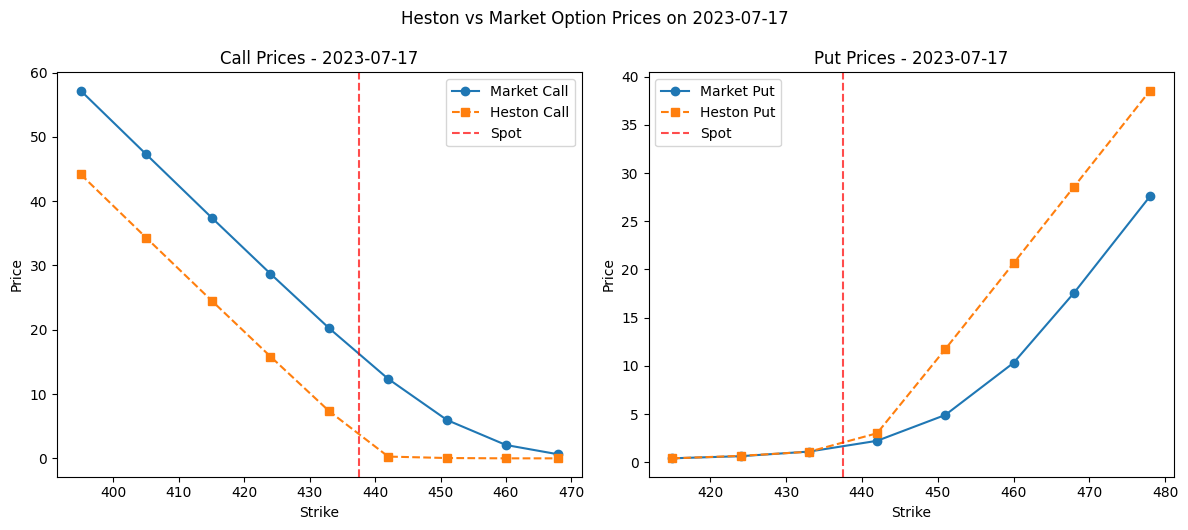

In [ ]:
# # Try use both call and put to calibrate
# selected_date = "2023-07-17"

# calibrated = calibration_results[selected_date]
# market_data = calibrated["market_data"]

# heston_process = HestonProcess(
#     kappa=calibrated["kappa"],
#     theta=calibrated["theta"],
#     sigma=calibrated["sigma"],
#     rho=calibrated["rho"],
#     v0=calibrated["v0"],
#     r=market_data["risk_free_rate"],
#     q=market_data["dividend_yield"]
# )
# pricer = HestonPricer(heston_process)

# # Price both calls and puts
# model_call_prices, model_put_prices = pricer.price_options(
#     call_strikes=market_data["call_strikes"],
#     put_strikes=market_data["put_strikes"],
#     S0=market_data["spot_price"],
#     T=market_data["time_to_expiry"]
# )

# # Plot
# plt.figure(figsize=(12, 5))

# # Calls
# plt.subplot(1, 2, 1)
# plt.plot(market_data["call_strikes"], market_data["call_market_prices"], 'o-', label='Market Call')
# plt.plot(market_data["call_strikes"], model_call_prices, 's--', label='Heston Call')
# plt.axvline(market_data["spot_price"], color='red', linestyle='--', alpha=0.7, label='Spot')
# plt.xlabel("Strike"); plt.ylabel("Price"); plt.title(f"Call Prices - {selected_date}"); plt.legend()

# # Puts
# plt.subplot(1, 2, 2)
# plt.plot(market_data["put_strikes"], market_data["put_market_prices"], 'o-', label='Market Put')
# plt.plot(market_data["put_strikes"], model_put_prices, 's--', label='Heston Put')
# plt.axvline(market_data["spot_price"], color='red', linestyle='--', alpha=0.7, label='Spot')
# plt.xlabel("Strike"); plt.ylabel("Price"); plt.title(f"Put Prices - {selected_date}"); plt.legend()

# plt.tight_layout()
# plt.suptitle(f"Heston vs Market Option Prices on {selected_date}", y=1.05)
# plt.show()

strategy with convergence exit

In [ ]:
class VolArbitrageStrategy:

    
    def __init__(self, mispricing_threshold=0.10, transaction_cost_pct=0.01):
    
        self.threshold = mispricing_threshold
        self.transaction_cost_pct = transaction_cost_pct
        self.trades = []
        self.positions = {}  # Track open positions
    
    def find_arbitrage_opportunities(self, date, call_data, calibration_results):
        """find mispriced options for a given date"""
        
        if date not in calibration_results or not calibration_results[date]['success']:
            return []
        
        if date not in call_data:
            return []

        calibrated = calibration_results[date]
        sample = call_data[date]

        heston_process = HestonProcess(
            kappa=calibrated['kappa'], theta=calibrated['theta'], 
            sigma=calibrated['sigma'], rho=calibrated['rho'], 
            v0=calibrated['v0'], r=sample['risk_free_rate']
        )
        heston_pricer = HestonPricer(heston_process)
        
        # heston fair values
        strikes = sample['prices'].index.values
        heston_prices = heston_pricer.fft_price(strikes, sample['spot_price'], sample['time_to_expiry'])
        
        opportunities = []
        
        for i, strike in enumerate(strikes):
            market_price = sample['prices'].iloc[i]
            heston_price = heston_prices[i]
            
            # mispricing percentage
            mispricing_pct = (market_price - heston_price) / heston_price
            
            # check if mispricing exceeds threshold  
            if abs(mispricing_pct) > self.threshold:
                
                # Create contract identifier
                contract_id = f"Call_{strike}_{sample['maturity']}"
                
                opportunities.append({
                    'date': date,
                    'contract_id': contract_id,
                    'strike': strike,
                    'expiry': sample['maturity'],
                    'market_price': market_price,
                    'heston_price': heston_price,
                    'mispricing_pct': mispricing_pct,
                    'signal': 'BUY' if mispricing_pct < -self.threshold else 'SELL',
                    'spot_price': sample['spot_price'],
                    'time_to_expiry': sample['time_to_expiry']
                })
        
        return opportunities
    
    def enter_position(self, opportunity, df):
        """Enter a new position"""
        
        # use actual bid/ask data for realistic entry price
        mask = (df['date'] == opportunity['date']) & \
               (df['strike'] == opportunity['strike']) & \
               (df['expiration'] == opportunity['expiry']) & \
               (df['call_put'] == 'Call')
        
        option_data = df[mask]
        
        if len(option_data) == 0:
            return None  # can't find the contract
        
        option_row = option_data.iloc[0]

        if opportunity['signal'] == 'BUY':
            entry_price = option_row['ask']  # buy at ask
        else:
            entry_price = option_row['bid']  # sell at bid
        
        position = {
            'entry_date': opportunity['date'],
            'contract_id': opportunity['contract_id'],
            'strike': opportunity['strike'],
            'expiry': opportunity['expiry'],
            'signal': opportunity['signal'],
            'entry_price': entry_price,
            'heston_price': opportunity['heston_price'],
            'mispricing_pct': opportunity['mispricing_pct'],
            'spot_at_entry': opportunity['spot_price']
        }
        
        return position
    
    def find_exit_price(self, position, date, df):
    
        # same contract
        mask = (df['date'] == date) & \
               (df['strike'] == position['strike']) & \
               (df['expiration'] == position['expiry']) & \
               (df['call_put'] == 'Call')
        
        option_data = df[mask]
        
        if len(option_data) == 0:
            return None  # skip 
        
        option_row = option_data.iloc[0]
     
        if position['signal'] == 'BUY':
            exit_price = option_row['bid']  # sell at bid when closing long
        else:
            exit_price = option_row['ask']  # buy at ask when closing short
            
        return {
            'exit_date': date,
            'exit_price': exit_price,
            'spot_at_exit': option_row['spot_price']
        }
    
    def calculate_pnl(self, position, exit_info):
        entry_price = position['entry_price']
        exit_price = exit_info['exit_price']
        
        # transaction costs (both entry and exit)
        entry_cost = entry_price * self.transaction_cost_pct
        exit_cost = exit_price * self.transaction_cost_pct
        total_transaction_costs = entry_cost + exit_cost
        
        if position['signal'] == 'BUY':
            # long: profit if exit > entry
            gross_pnl = exit_price - entry_price
        else:
            # short: profit if entry > exit  
            gross_pnl = entry_price - exit_price
        
        # net P&L after transaction costs
        net_pnl = gross_pnl - total_transaction_costs
        net_pnl_pct = net_pnl / entry_price
        
        return {
            'pnl': net_pnl,
            'pnl_pct': net_pnl_pct,
            'gross_pnl': gross_pnl,
            'transaction_costs': total_transaction_costs,
            'days_held': (pd.to_datetime(exit_info['exit_date']) - 
                         pd.to_datetime(position['entry_date'])).days
        }
    
    def should_exit_position(self, position, current_date, call_data, calibration_results, df):
        # First check if we can get current market data
        exit_info = self.find_exit_price(position, current_date, df)
        if not exit_info:
            return False, None, None  # Can't exit - contract not available
        
        current_market_price = exit_info['exit_price']
   
        if current_date not in calibration_results or not calibration_results[current_date]['success']:
            return False, None, None  
        
        if current_date not in call_data:
            return False, None, None  # No market data for calibration
            
        calibrated = calibration_results[current_date]
        sample = call_data[current_date]
        
        # heston pricer with current parameters
        heston_process = HestonProcess(
            kappa=calibrated['kappa'], theta=calibrated['theta'], 
            sigma=calibrated['sigma'], rho=calibrated['rho'], 
            v0=calibrated['v0'], r=sample['risk_free_rate']
        )
        heston_pricer = HestonPricer(heston_process)
        
        # find current Heston price for our strike
        try:
            # Check if our strike is in current calibration data
            if position['strike'] not in sample['prices'].index:
                return False, None, None  
                
            current_heston_price = heston_pricer.fft_price(
                [position['strike']], sample['spot_price'], sample['time_to_expiry']
            )[0]
        except:
            return False, None, None  # pricing failed
  
        current_mispricing_pct = abs(current_market_price - current_heston_price) / current_heston_price
        
        # unrealized P&L
        if position['signal'] == 'BUY':
            unrealized_pnl = current_market_price - position['entry_price']
        else:
            unrealized_pnl = position['entry_price'] - current_market_price
        
        # days held so far
        days_held = (pd.to_datetime(current_date) - pd.to_datetime(position['entry_date'])).days
        
        # EXIT RULES:
        
        # Rule 1: Convergence - mispricing corrected
        if current_mispricing_pct < 0.02:  # 2% convergence threshold
            return True, "convergence", exit_info
        
        # Rule 2: Stop loss - losing more than 50% of entry price
        entry_cost = position['entry_price'] * self.transaction_cost_pct
        stop_loss_threshold = -(position['entry_price'] * 0.5 + entry_cost)
        if unrealized_pnl < stop_loss_threshold:
            return True, "stop_loss", exit_info
        
        # Rule 3: Time decay risk - less than 7 days to expiry
        if sample['time_to_expiry'] * 365 < 7:  # Convert years to days
            return True, "expiry_risk", exit_info
        
        # Rule 4: Maximum hold period - 15 days max
        if days_held >= 15:
            return True, "max_hold", exit_info
        
        # Rule 5: Profit taking - made more than 100% return
        profit_threshold = position['entry_price'] * 1.0  # 100% profit
        if unrealized_pnl > profit_threshold:
            return True, "profit_take", exit_info
            
        return False, None, None  # Hold position

    def run_backtest(self, call_data, calibration_results, df, max_hold_days=15):
        """Run the complete arbitrage backtest with CONVERGENCE-BASED exits"""
        
        print("Running Vol Arbitrage Backtest...")
        print("CONVERGENCE-BASED EXIT STRATEGY:")
        print(f"  - Exit if mispricing < 2% (convergence)")
        print(f"  - Exit if loss > 50% of entry price (stop loss)")
        print(f"  - Exit if < 7 days to expiry (time decay risk)")
        print(f"  - Exit if held > {max_hold_days} days (max hold)")
        print(f"  - Exit if profit > 100% (profit taking)")
        print(f"Transaction Cost: {self.transaction_cost_pct:.1%} per trade")
        print("=" * 50)
        
        all_trades = []
        open_positions = []  # Track positions waiting for exit
        dates = sorted(call_data.keys())
        
        for i, date in enumerate(dates):
            print(f"\nProcessing {date}...")
            
            # Find arbitrage opportunities
            opportunities = self.find_arbitrage_opportunities(date, call_data, calibration_results)
            print(f"  Found {len(opportunities)} opportunities")
            
            # Enter new positions
            new_positions = []
            for opp in opportunities:
                position = self.enter_position(opp, df)
                if position:
                    position['entry_date_idx'] = i  # Store index for tracking
                    new_positions.append(position)
                    open_positions.append(position)
            
            print(f"  Entered {len(new_positions)} new positions")
            
            # Check exits for existing open positions
            positions_to_close = []
            for pos in open_positions[:]:  # Copy list to modify during iteration
                should_exit, exit_reason, exit_info = self.should_exit_position(
                    pos, date, call_data, calibration_results, df
                )
                
                if should_exit:
                    # Calculate P&L and close position
                    pnl_info = self.calculate_pnl(pos, exit_info)
                    completed_trade = {**pos, **exit_info, **pnl_info, 'exit_reason': exit_reason}
                    all_trades.append(completed_trade)
                    open_positions.remove(pos)
                    
                    print(f"    Closed {pos['signal']} {pos['strike']} - Reason: {exit_reason} - Net P&L: ${pnl_info['pnl']:.2f}")
            
            print(f"  Open positions: {len(open_positions)}")
        
        print(f"\nBacktest completed!")
        print(f"Total completed trades: {len(all_trades)}")
        print(f"Remaining open positions: {len(open_positions)} (will be ignored)")
        
        self.trades = all_trades
        return self.analyze_results()
    
    def analyze_results(self):
        """Analyze backtest results"""
        
        if not self.trades:
            return {"message": "No completed trades"}
        
        trades_df = pd.DataFrame(self.trades)
        
        # Basic statistics
        total_trades = len(trades_df)
        winning_trades = len(trades_df[trades_df['pnl'] > 0])
        win_rate = winning_trades / total_trades
        
        avg_pnl = trades_df['pnl'].mean()
        total_pnl = trades_df['pnl'].sum()
        avg_hold_days = trades_df['days_held'].mean()
        
        # Separate by signal
        buy_trades = trades_df[trades_df['signal'] == 'BUY']
        sell_trades = trades_df[trades_df['signal'] == 'SELL']
        
        # Calculate gross vs net P&L
        total_gross_pnl = trades_df['gross_pnl'].sum() if 'gross_pnl' in trades_df.columns else 0
        total_transaction_costs = trades_df['transaction_costs'].sum() if 'transaction_costs' in trades_df.columns else 0
        
        # Exit reason analysis
        exit_reason_counts = trades_df['exit_reason'].value_counts() if 'exit_reason' in trades_df.columns else {}
        
        results = {
            'total_trades': total_trades,
            'win_rate': win_rate,
            'avg_pnl': avg_pnl,
            'total_pnl': total_pnl,
            'total_gross_pnl': total_gross_pnl,
            'total_transaction_costs': total_transaction_costs,
            'avg_hold_days': avg_hold_days,
            'buy_trades': len(buy_trades),
            'sell_trades': len(sell_trades),
            'buy_avg_pnl': buy_trades['pnl'].mean() if len(buy_trades) > 0 else 0,
            'sell_avg_pnl': sell_trades['pnl'].mean() if len(sell_trades) > 0 else 0,
            'exit_reasons': exit_reason_counts,
            'trades_df': trades_df
        }
        
        return results

In [ ]:
def run_arbitrage_backtest(df, call_data, calibration_results, threshold=0.15, transaction_cost_pct=0.01):

    
    strategy = VolArbitrageStrategy(mispricing_threshold=threshold, transaction_cost_pct=transaction_cost_pct)
    results = strategy.run_backtest(call_data, calibration_results, df)
    print(f"Total Trades: {results['total_trades']}")
    print(f"Win Rate: {results['win_rate']:.1%}")
    print(f"Average Net P&L per trade: ${results['avg_pnl']:.2f}")
    print(f"Total Net P&L: ${results['total_pnl']:.2f}")
    print(f"Total Gross P&L: ${results['total_gross_pnl']:.2f}")
    print(f"Total Transaction Costs: ${results['total_transaction_costs']:.2f}")
    print(f"Average Hold Days: {results['avg_hold_days']:.1f}")
    print(f"\nBuy Trades: {results['buy_trades']} (avg P&L: ${results['buy_avg_pnl']:.2f})")
    print(f"Sell Trades: {results['sell_trades']} (avg P&L: ${results['sell_avg_pnl']:.2f})")
    
    if 'exit_reasons' in results and len(results['exit_reasons']) > 0:
        print(f"\nEXIT REASONS:")
        for reason, count in results['exit_reasons'].items():
            print(f"  {reason}: {count} trades")
    
    return strategy, results

Running Vol Arbitrage Backtest...
CONVERGENCE-BASED EXIT STRATEGY:
  - Exit if mispricing < 2% (convergence)
  - Exit if loss > 50% of entry price (stop loss)
  - Exit if < 7 days to expiry (time decay risk)
  - Exit if held > 15 days (max hold)
  - Exit if profit > 100% (profit taking)
Transaction Cost: 1.0% per trade

Processing 2023-07-17...
  Found 6 opportunities
  Entered 6 new positions
  Open positions: 6

Processing 2023-07-19...
  Found 6 opportunities
  Entered 6 new positions
  Open positions: 12

Processing 2023-07-21...
  Found 5 opportunities
  Entered 5 new positions
  Open positions: 17

Processing 2023-07-24...
  Found 5 opportunities
  Entered 5 new positions
  Open positions: 22

Processing 2023-07-26...
  Found 5 opportunities
  Entered 5 new positions
  Open positions: 27

Processing 2023-07-28...
  Found 5 opportunities
  Entered 5 new positions
  Open positions: 32

Processing 2023-07-31...
  Found 5 opportunities
  Entered 5 new positions
  Open positions: 37



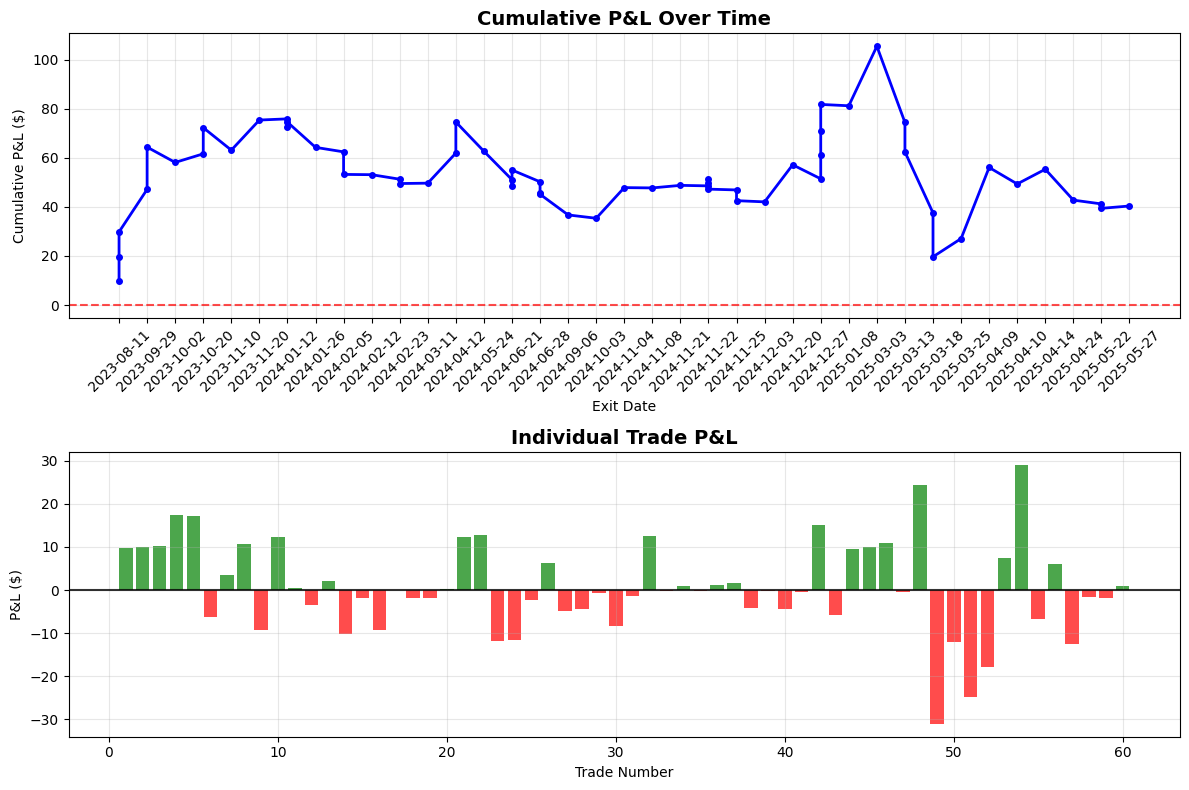


📊 Plotting Performance Metrics...


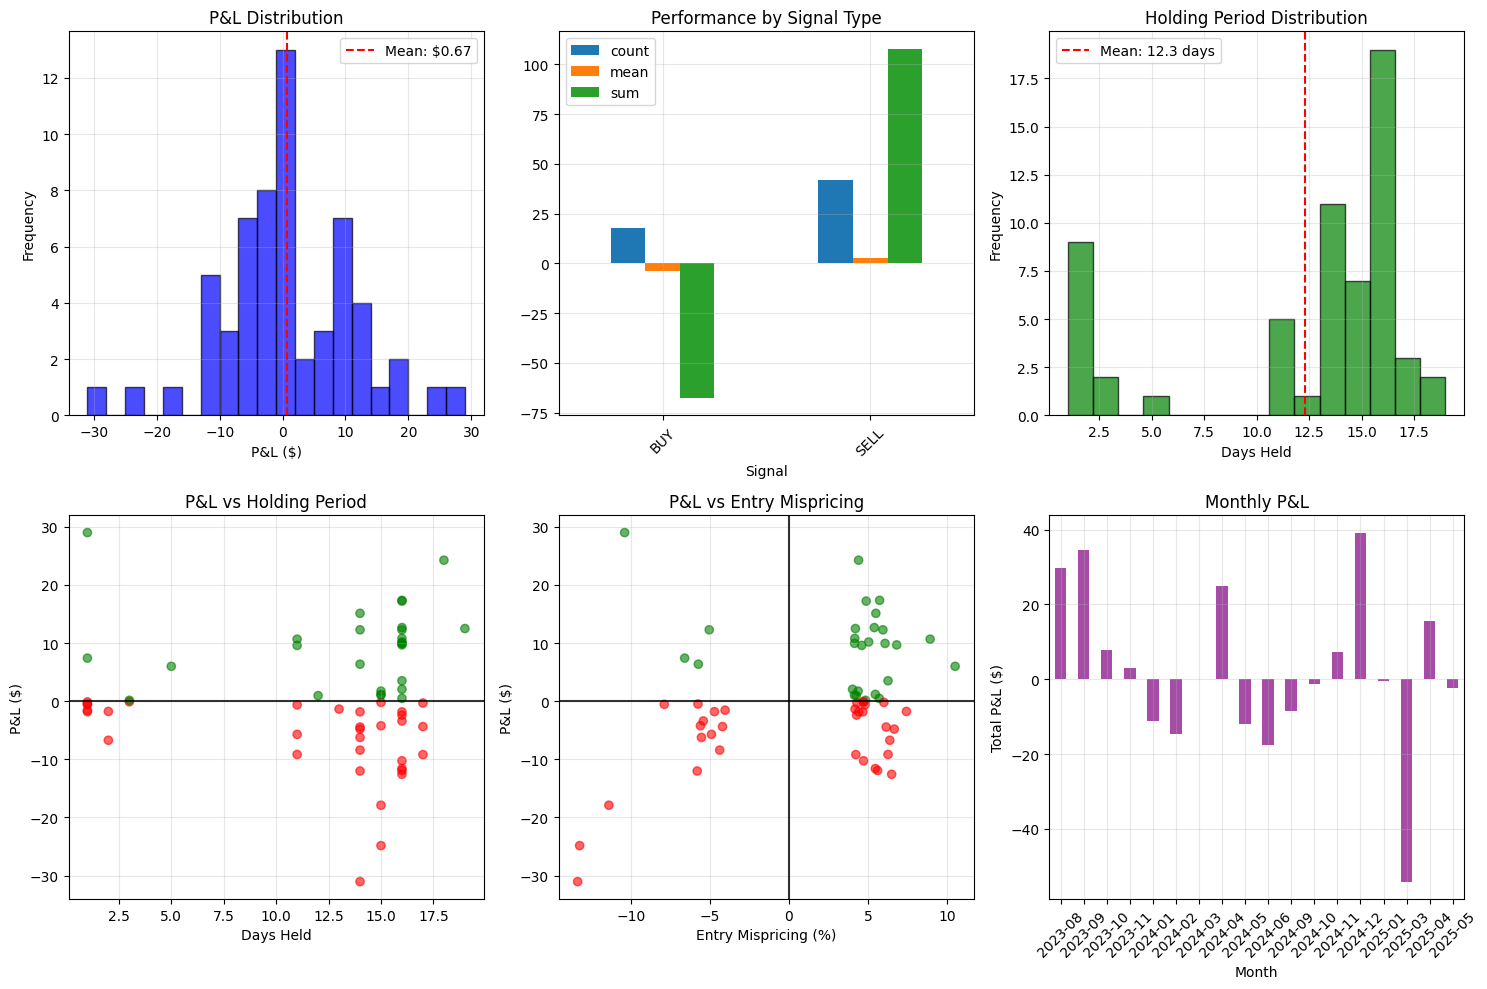


💰 Plotting Equity Curve...


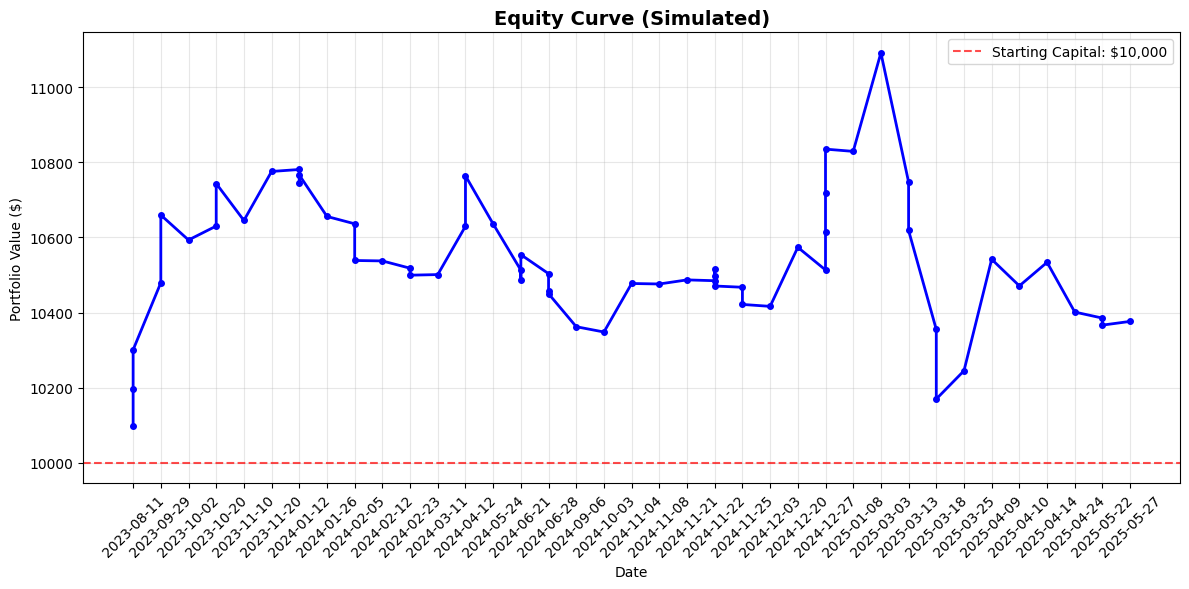


💼 PORTFOLIO SIMULATION:
   Starting Capital: $10,000
   Final Value: $10,376.40
   Total Return: 3.8%


In [63]:
# Run convergence-based strategy
strategy, results = run_arbitrage_backtest(
    df=df,
    call_data=call_data,
    calibration_results=calibration_results,
    threshold=0.04,           
    transaction_cost_pct=0.01 # 1% costs
)

# Same analysis tools work!
analyzer = analyze_strategy_results(strategy, results)